In [1]:
from plugins import plot_data

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

In [3]:
%ripl --seed 1 --plugins plugins.py

Set seed of a new VentureScript RIPL to 1.00.
Loading plugin: plugins.py


In [4]:
%%venturescript
define component_1 = () -> {normal(10, 0.3)};
define component_2 = () -> {normal(1, 1)};
define gmm = (_) -> {
    if(flip()) {
        component_1()
    } else {
        component_2()
    }
};
define training_data = mapv(gmm, arange(100));
define test_data = mapv(gmm, arange(100));
define data_to_render_curve = mapv(gmm, arange(10**5));

save_csv("training_data.csv", training_data);
save_csv("test_data.csv", test_data);
save_csv("data_to_render_curve.csv", data_to_render_curve);

In [5]:
%%venturescript
// MODEL
assume alpha ~ gamma(1.0, 1.0) #concentration ;
assume assign = make_crp(alpha) ;
assume z = mem((row) ~> { assign() #cluster_assignment:row });
assume V = mem((col) ~> { gamma(1.0, 1.0) #relative_variance:col });
assume component = mem((z, col) ~> {make_nig_normal(0.0, V(1), 1.0, 1.0) });
// Load synthetic data
define training_data = load_csv(str_concat(get_path(), "/training_data.csv"));
define test_data = load_csv(str_concat(get_path(), "/test_data.csv"));

In [6]:
training_data        = %venturescript training_data
test_data            = %venturescript test_data

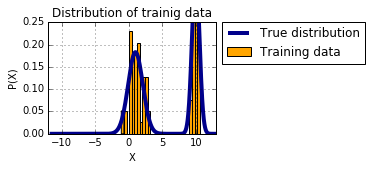

In [7]:
fig, ax = plot_data(training_data, 'Training data', title='Distribution of trainig data')

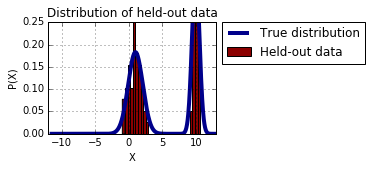

In [8]:
fig, ax = plot_data(test_data, 'Held-out data', title='Distribution of held-out data', color='darkred')

In [9]:
%%venturescript
// OBSERVATIONS
for_each(
    arange(size(training_data)),
    (i) -> {
        observe component(z(atom($i)), 1)() = training_data[i]      
    }
);

In [10]:
%%venturescript
// INFERENCE
define single_site_mh = () -> {
    mh(default, one, 1)    
};

define resimulation_mh = () -> {
    mh(default, all, 1)    
};

In [11]:
%%venturescript
define prior_samples = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 100)
);

In [12]:
prior_samples = %venturescript prior_samples

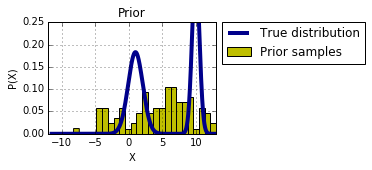

In [13]:
fig, ax = plot_data(prior_samples, 'Prior samples', title='Prior', color='y')

In [14]:
%%venturescript
mh(default, one, 15000)

[7.948933333333334]

In [15]:
%%venturescript
define posterior_samples = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 100)
);

In [16]:
posterior_samples = %venturescript posterior_samples

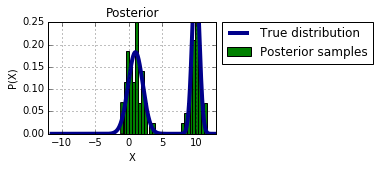

In [17]:
fig, ax = plot_data(posterior_samples, 'Posterior samples', title='Posterior', color='g')